In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader

In [2]:
class LayerNormalization(nn.Module):
    def __init__(self,emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))
        
    def forward(self,idx):
        mean = idx.mean(dim=-1,keepdim = True)
        var = idx.var(dim = -1,keepdim =True,unbiased = False)
        norm_x = (idx - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

In [3]:
class MultiHeadattation(nn.Module):
    
    def __init__(self,d_in,d_out,context_length,dropout,num_heads,qkv_bias = False):
        super().__init__()
        
        assert (d_out % num_heads == 0), \
        'number of heads must be lower then dimension out'
        
        self.register_buffer('mask',torch.triu(torch.ones(context_length,context_length),diagonal = 1))
        self.d_out  = d_out
        self.num_heads = num_heads
        self.out_proj = nn.Linear(d_out, d_out)
        self.head_dim = self.d_out // self.num_heads
        self.q_weight = nn.Linear(d_in,d_out,bias = qkv_bias)
        self.k_weight = nn.Linear(d_in,d_out,bias = qkv_bias)
        self.v_weight = nn.Linear(d_in,d_out,bias = qkv_bias)
        self.dropout  = nn.Dropout(dropout)
        
    def forward(self,idx):
        batch,num_tokens,d_in = idx.shape
        q_matrix = self.q_weight(idx)
        k_matrix = self.k_weight(idx)
        v_matrix = self.v_weight(idx)
        
        query = q_matrix.view(batch,num_tokens,self.num_heads,self.head_dim)
        key = k_matrix.view(batch,num_tokens,self.num_heads,self.head_dim)
        value = v_matrix.view(batch,num_tokens,self.num_heads,self.head_dim)
        
        query = query.transpose(1,2)
        key = key.transpose(1,2)
        value = value.transpose(1,2)
        
        attention_score = query @ key.transpose(2,3)
        masked_matrix = attention_score.masked_fill(self.mask.bool()[:num_tokens,:num_tokens],-torch.inf)
        attention_weight = torch.softmax(masked_matrix / idx.shape[-1] ** 0.5,dim=-1)
        
        attention_weight = self.dropout(attention_weight)
        context_vec = (attention_weight @ value).transpose(1,2)
        context_vec = context_vec.contiguous().view(batch,num_tokens,self.d_out)
        context_vec = self.out_proj(context_vec)
        
        return context_vec

In [4]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) * 
            (x + 0.044715 * torch.pow(x, 3))
        ))

In [5]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )

    def forward(self, x):
        return self.layers(x)

In [6]:
class Transformerblock(nn.Module):
    def __init__(self,cfg):
        super().__init__()
        self.MultiHeadattation_instance = MultiHeadattation(cfg['emb_dim'],cfg['emb_dim'],cfg['context_length'],cfg['drop_rate'],cfg['num_heads'])
        self.att = MultiHeadattation(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["num_heads"], 
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNormalization(cfg["emb_dim"])
        self.norm2 = LayerNormalization(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])
    
    def forward(self,x):
        
        shortcut = x
        x = self.norm1(x)
        x = self.att(x) 
        x = self.drop_shortcut(x)
        x = x + shortcut  
        
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut 

        return x

In [7]:
class GPT2(nn.Module):
    def __init__(self,cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        
        self.trf_blocks = nn.Sequential(
            *[Transformerblock(cfg) for _ in range(cfg["num_layers"])])
        
        self.final_norm = LayerNormalization(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, idx):
        batch_size, seq_len = idx.shape
        tok_embeds = self.tok_emb(idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=idx.device))
        idx = tok_embeds + pos_embeds 
        idx = self.drop_emb(idx)
        idx = self.trf_blocks(idx)
        idx = self.final_norm(idx)
        logits = self.out_head(idx)
        return logits
        

In [8]:
GPT_Cfg = {
    'num_heads' : 12,
    'num_layers' : 12,
    'drop_rate' : 0.1,
    'qkv_bias' : False,
    'emb_dim' : 768,
    'context_length' : 1024,
    'vocab_size'  : 50257,
}

In [9]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"
batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [10]:
dummygpt = GPT2(GPT_Cfg)
result = dummygpt(batch)
result

tensor([[[ 0.0742, -0.8474,  0.6043,  ..., -0.1689,  0.1578,  0.1192],
         [ 0.5202,  0.3038, -0.4188,  ..., -0.1988, -0.2917, -0.3180],
         [ 0.1320, -0.0914, -0.1178,  ...,  0.8987, -0.6488,  0.3303],
         [ 1.0237,  0.6220, -0.3833,  ..., -0.2747, -0.9521,  0.2339]],

        [[ 0.4899, -0.6184,  0.0449,  ..., -0.3236,  0.3216,  0.2945],
         [-0.2956, -0.7793,  0.8040,  ..., -0.0736, -0.1223, -0.0954],
         [ 1.3290, -0.3468,  0.4233,  ..., -0.1219, -0.5837, -0.4454],
         [ 0.0691, -0.0366,  0.1129,  ..., -0.2452, -0.2557, -0.2038]]],
       grad_fn=<UnsafeViewBackward0>)

In [11]:
total_parameters = sum(p.numel() for p in dummygpt.parameters())
print(f"Total Number Of Parameters are :{total_parameters:,}")

Total Number Of Parameters are :191,330,304


In [12]:
def generate_new_text(idx,max_iteration,model,context_size):
    
    for _ in range(max_iteration):
        idx_new = idx[:,-context_size:]
        
        with torch.no_grad():
            logits = model(idx_new)
            
        new_logits = logits[:,-1,:]
        probas = torch.softmax(new_logits,dim=-1)
        max_probas = torch.argmax(probas,dim=-1,keepdim=True)
        
        idx = torch.concat((idx,max_probas),dim=-1)
        
    return idx

In [13]:
text = "my name"
toknized_text = tokenizer.encode(text)
print("Tokenized text is : ",toknized_text)
new_tokenized_text = torch.tensor(toknized_text).unsqueeze(0)
print("Tokenized text shape is : ",new_tokenized_text.shape)

Tokenized text is :  [1820, 1438]
Tokenized text shape is :  torch.Size([1, 2])


In [14]:
predict = generate_new_text(
    idx = new_tokenized_text,
    max_iteration = 6,
    model = dummygpt,
    context_size = GPT_Cfg['context_length']
)

print("output tensor is :",predict)

output tensor is : tensor([[ 1820,  1438, 26476, 14693,  7776, 15800,  2535, 42499]])


In [15]:
uncoded_text = tokenizer.decode(predict.squeeze(0).tolist())
print(uncoded_text)

my name discharged alternatives gaming shyitting aber


In [16]:
inputs = torch.tensor([[16833, 3626, 6100],   # ["every effort moves",
                    [40,    1107, 588]])   #  "I really like"]

targets = torch.tensor([[3626, 6100, 345  ],  # [" effort moves you",
                        [1107,  588, 11311]])

In [17]:
with torch.no_grad():
    logits = dummygpt(inputs)

In [18]:
probas = torch.softmax(logits,dim=-1)
print(probas.shape)

torch.Size([2, 3, 50257])


In [19]:
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print("Token IDs:\n", token_ids)

Token IDs:
 tensor([[[38411],
         [24759],
         [19222]],

        [[21434],
         [14508],
         [29361]]])


In [20]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,   # Vocabulary size
    "context_length": 256, # Shortened context length (orig: 1024)
    "emb_dim": 768,        # Embedding dimension
    "num_heads": 12,         # Number of attention heads
    "num_layers": 12,        # Number of layers
    "drop_rate": 0.1,      # Dropout rate
    "qkv_bias": False      # Query-key-value bias
}

torch.manual_seed(123)
model = GPT2(GPT_CONFIG_124M)
model.eval()

GPT2(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): Transformerblock(
      (MultiHeadattation_instance): MultiHeadattation(
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (q_weight): Linear(in_features=768, out_features=768, bias=False)
        (k_weight): Linear(in_features=768, out_features=768, bias=False)
        (v_weight): Linear(in_features=768, out_features=768, bias=False)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (att): MultiHeadattation(
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (q_weight): Linear(in_features=768, out_features=768, bias=False)
        (k_weight): Linear(in_features=768, out_features=768, bias=False)
        (v_weight): Linear(in_features=768, out_features=768, bias=False)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (la

In [21]:
def token_ids_to_text(idx,tokenizer):
    encoded_text =  idx.squeeze(0)
    return  tokenizer.decode(encoded_text.tolist())

def text_to_token_ids(text,tokenizer):
    decoded_text =  tokenizer.encode(text,allowed_special={'<|endoftext|>'})
    decoded_tensor = torch.tensor(decoded_text).unsqueeze(0)
    return  decoded_tensor

class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})

        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

def create_dataloader_v1(txt, batch_size=4, max_length=256, 
                        stride=128, shuffle=True, drop_last=True,
                        num_workers=0):

    tokenizer = tiktoken.get_encoding("gpt2")
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)

    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers
    )

    return dataloader

In [22]:
print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Outputs batch 1: {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

Targets batch 1:  effort moves you
Outputs batch 1:  whims Wool dull


In [23]:
text_idx = 0
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 1:", target_probas_1)

text_idx = 1
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 2:", target_probas_2)

Text 1: tensor([2.5397e-05, 2.2672e-05, 3.7386e-05])
Text 2: tensor([1.0684e-05, 1.0179e-05, 2.1199e-05])


In [24]:
log = torch.log(torch.cat((target_probas_1,target_probas_2)))
log

tensor([-10.5809, -10.6944, -10.1942, -11.4468, -11.4951, -10.7616])

In [25]:
avg_log = torch.mean(log)
print(avg_log)

tensor(-10.8622)


In [26]:
neg_avg_log_probas = avg_log * -1
print(neg_avg_log_probas)

tensor(10.8622)


In [27]:
# Logits have shape (batch_size, num_tokens, vocab_size)
print("Logits shape:", logits.shape)

# Targets have shape (batch_size, num_tokens)
print("Targets shape:", targets.shape)

Logits shape: torch.Size([2, 3, 50257])
Targets shape: torch.Size([2, 3])


In [28]:
logits_flat = logits.flatten(0, 1)
targets_flat = targets.flatten()

print("Flattened logits:", logits_flat.shape)
print("Flattened targets:", targets_flat.shape)

Flattened logits: torch.Size([6, 50257])
Flattened targets: torch.Size([6])


In [29]:
loss = torch.nn.functional.cross_entropy(logits_flat,targets_flat)
print(loss)

tensor(10.8622)


In [30]:
perplexity = torch.exp(loss)
print(perplexity)

tensor(52164.6680)


In [31]:
import os
import urllib.request

file_path = "the-verdict.txt"
url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt"

if not os.path.exists(file_path):
    with urllib.request.urlopen(url) as responce:
        text_data = responce.read().decode('utf-8')
    with open(file_path,'w',encoding='utf-8') as responce:
        responce.write(text_data)
else:
    with open(file_path, "r", encoding="utf-8") as file:
        text_data = file.read()

In [32]:
print(text_data[:99])

I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no 


In [33]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))

print("Characters:", total_characters)
print("Tokens:", total_tokens)

Characters: 20479
Tokens: 5145


In [34]:
train_ratio = 0.9
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0)


In [35]:
for x,y in train_loader:
    print(x.shape,y.shape)
 
print('val_loader')
for x,y in val_loader:
    print(x.shape,y.shape)


torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
val_loader
torch.Size([2, 256]) torch.Size([2, 256])


In [36]:
train_tokens = 0
for input_batch, target_batch in train_loader:
    train_tokens += input_batch.numel()

val_tokens = 0
for input_batch, target_batch in val_loader:
    val_tokens += input_batch.numel()

print("Training tokens:", train_tokens)
print("Validation tokens:", val_tokens)
print("All tokens:", train_tokens + val_tokens)

Training tokens: 4608
Validation tokens: 512
All tokens: 5120


In [37]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss


def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [38]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model.to(device)
torch.manual_seed(123)

with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 10.979520161946615
Validation loss: 11.009520530700684


In [39]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_new_text(
            model=model, idx=encoded,
            max_iteration=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))  # Compact print format
    model.train()

In [40]:
def train_model(train_loader,val_loader,optimizer,model,device,num_epochs,eval_freq,eval_iter
                ,start_context,tokenizer):
    train_losses,val_losses,track_tokens_seen = [],[],[]
    tokens_seen,global_step = 0,-1
    
    for epoch in range(num_epochs):
        model.train()
        
        for input_batch,target_batch in train_loader:
            optimizer.zero_grad()
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()
            optimizer.step()
            tokens_seen += input_batch.numel()
            
            global_step += 1
            
            if global_step % eval_freq == 0: 
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                    f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")
                
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen   

In [41]:
import time 
start_time = time.time()
torch.manual_seed(123)
model = GPT2(GPT_CONFIG_124M)
optimizer = torch.optim.AdamW(model.parameters(),lr=0.0004,weight_decay=0.1)

num_epoches = 10
train_loss,val_loss,token_seen = train_model(
    train_loader,val_loader,optimizer,model,device,num_epoches,5,5,start_context="Every effort moves you", tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 9.904, Val loss 10.037
Ep 1 (Step 000005): Train loss 8.096, Val loss 8.263
Every effort moves you,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Ep 2 (Step 000010): Train loss 6.719, Val loss 6.988
Ep 2 (Step 000015): Train loss 5.925, Val loss 6.508
Every effort moves you, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and
Ep 3 (Step 000020): Train loss 5.785, Val loss 6.436
Ep 3 (Step 000025): Train loss 5.284, Val loss 6.471
Every effort moves youburnburnburn'sburn Jacketburn's �isburn Truth SetTextColor.                                    
Ep 4 (Step 000030): Train loss 5.609, Val loss 6.565
Ep 4 (Step 000035): Train loss 5.361, Val loss 6.455
Every effort moves you, the, the of the, the of the the--. Gis of the, the was, the. ". Gis the., the of the my, the. Gis the of the of the. Gis the of
Ep 5 (Step 000040): Train loss 4.897, Val loss 6.379
Every effort moves you I felt  

In [44]:
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_new_text(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_iteration=25,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you of Jack Gisburn's a cheap genius--though a good fellow enough--so it was no great surprise to me to


In [45]:
next_token_logits = torch.tensor(
[4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79])

In [46]:
vocab = { 
    "closer": 0,
    "every": 1, 
    "effort": 2, 
    "forward": 3,
    "inches": 4,
    "moves": 5, 
    "pizza": 6,
    "toward": 7,
    "you": 8,
} 

inverse_vocab = {v: k for k, v in vocab.items()}

In [47]:
probas = torch.softmax(next_token_logits, dim=0)
next_token_id = torch.argmax(probas).item()
print(inverse_vocab[next_token_id])

forward


In [48]:
torch.manual_seed(123)
next_token_id = torch.multinomial(probas, num_samples=1).item()
print(inverse_vocab[next_token_id])

toward


In [49]:
def print_sampled_tokens(probas):
    torch.manual_seed(123)
    sample = [torch.multinomial(probas, num_samples=1).item() for i in range(1_000)]
    sampled_ids = torch.bincount(torch.tensor(sample))
    for i, freq in enumerate(sampled_ids):
        print(f"{freq} x {inverse_vocab[i]}")

print_sampled_tokens(probas)

71 x closer
2 x every
0 x effort
544 x forward
2 x inches
1 x moves
0 x pizza
376 x toward
4 x you


In [50]:
def softmax_with_temperature(logits, temperature):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim=0)

temperatures = [1, 0.1, 5]

scaled_probas = [softmax_with_temperature(next_token_logits, T) for T in temperatures]

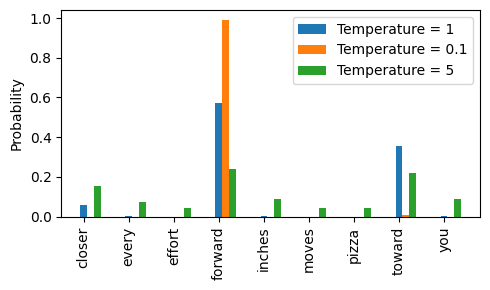

In [53]:
import matplotlib.pyplot as plt

x = torch.arange(len(vocab))
bar_width = 0.15

fig, ax = plt.subplots(figsize=(5, 3))
for i, T in enumerate(temperatures):
    rects = ax.bar(x + i * bar_width, scaled_probas[i], bar_width, label=f'Temperature = {T}')

ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()

plt.tight_layout()
plt.savefig("temperature-plot.pdf")
plt.show()

In [54]:
next_token_logits = torch.tensor(
[4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

In [55]:
top_k = 3
top_logits, top_pos = torch.topk(next_token_logits, top_k)
print("Top logits:", top_logits)
print("Top positions:", top_pos)

Top logits: tensor([6.7500, 6.2800, 4.5100])
Top positions: tensor([3, 7, 0])


In [56]:
new_logits = torch.where(
    condition=next_token_logits < top_logits[-1],
    input=torch.tensor(float("-inf")), 
    other=next_token_logits
)

print(new_logits)

tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])


In [57]:
topk_probas = torch.softmax(new_logits, dim=0)
print(topk_probas)

tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])


In [58]:
from gpt_download3 import download_and_load_gpt2

In [64]:
settings,params = download_and_load_gpt2(model_size="124M", models_dir="gpt2")

C:\Users\prate\AppData\Roaming\Python\Python311\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2\124M\checkpoint


C:\Users\prate\AppData\Roaming\Python\Python311\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2\124M\encoder.json


C:\Users\prate\AppData\Roaming\Python\Python311\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2\124M\hparams.json


C:\Users\prate\AppData\Roaming\Python\Python311\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2\124M\model.ckpt.data-00000-of-00001


C:\Users\prate\AppData\Roaming\Python\Python311\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2\124M\model.ckpt.index


C:\Users\prate\AppData\Roaming\Python\Python311\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2\124M\model.ckpt.meta


C:\Users\prate\AppData\Roaming\Python\Python311\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2\124M\vocab.bpe


In [59]:
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "num_layers": 12, "num_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "num_layers": 24, "num_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "num_layers": 36, "num_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "num_layers": 48, "num_heads": 25},
}

# Copy the base configuration and update with specific model settings
model_name = "gpt2-small (124M)"  # Example model name
NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update(model_configs[model_name])

In [60]:
NEW_CONFIG.update({"context_length": 1024, "qkv_bias": True})
gpt = GPT2(NEW_CONFIG)
gpt.eval()

GPT2(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): Transformerblock(
      (MultiHeadattation_instance): MultiHeadattation(
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (q_weight): Linear(in_features=768, out_features=768, bias=False)
        (k_weight): Linear(in_features=768, out_features=768, bias=False)
        (v_weight): Linear(in_features=768, out_features=768, bias=False)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (att): MultiHeadattation(
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (q_weight): Linear(in_features=768, out_features=768, bias=True)
        (k_weight): Linear(in_features=768, out_features=768, bias=True)
        (v_weight): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (laye

In [61]:
def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))

In [62]:
import numpy as np

def load_weights_into_gpt(gpt, params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])
    
    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.trf_blocks[b].att.q_weight.weight = assign(
            gpt.trf_blocks[b].att.q_weight.weight, q_w.T)
        gpt.trf_blocks[b].att.k_weight.weight = assign(
            gpt.trf_blocks[b].att.k_weight.weight, k_w.T)
        gpt.trf_blocks[b].att.v_weight.weight = assign(
            gpt.trf_blocks[b].att.v_weight.weight, v_w.T)

        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.trf_blocks[b].att.q_weight.bias = assign(
            gpt.trf_blocks[b].att.q_weight.bias, q_b)
        gpt.trf_blocks[b].att.k_weight.bias = assign(
            gpt.trf_blocks[b].att.k_weight.bias, k_b)
        gpt.trf_blocks[b].att.v_weight.bias = assign(
            gpt.trf_blocks[b].att.v_weight.bias, v_b)

        gpt.trf_blocks[b].att.out_proj.weight = assign(
            gpt.trf_blocks[b].att.out_proj.weight, 
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].att.out_proj.bias = assign(
            gpt.trf_blocks[b].att.out_proj.bias, 
            params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.trf_blocks[b].ff.layers[0].weight = assign(
            gpt.trf_blocks[b].ff.layers[0].weight, 
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias, 
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight, 
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias, 
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale, 
            params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift, 
            params["blocks"][b]["ln_1"]["b"])
        gpt.trf_blocks[b].norm2.scale = assign(
            gpt.trf_blocks[b].norm2.scale, 
            params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift, 
            params["blocks"][b]["ln_2"]["b"])

    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])


In [65]:
load_weights_into_gpt(gpt, params)
gpt.to(device)

GPT2(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): Transformerblock(
      (MultiHeadattation_instance): MultiHeadattation(
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (q_weight): Linear(in_features=768, out_features=768, bias=False)
        (k_weight): Linear(in_features=768, out_features=768, bias=False)
        (v_weight): Linear(in_features=768, out_features=768, bias=False)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (att): MultiHeadattation(
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (q_weight): Linear(in_features=768, out_features=768, bias=True)
        (k_weight): Linear(in_features=768, out_features=768, bias=True)
        (v_weight): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (laye

In [66]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        if top_k is not None:
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)
        if temperature > 0.0:
            logits = logits / temperature
            probs = torch.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch_size, 1)

        if idx_next == eos_id:
            break
        idx = torch.cat((idx, idx_next), dim=1)

    return idx

In [67]:
torch.manual_seed(123)

token_ids = generate(
    model=gpt,
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(device),
    max_new_tokens=25,
    context_size=NEW_CONFIG["context_length"],
    top_k=50,
    temperature=1.4
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you have have a in for a a from it was of
 to a not there at a that been a I to a the


In [68]:
import urllib.request
import ssl
import zipfile
import os
from pathlib import Path

url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = "sms_spam_collection.zip"
extracted_path = "sms_spam_collection"
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"

def download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path):
    if data_file_path.exists():
        print(f"{data_file_path} already exists. Skipping download and extraction.")
        return

    ssl_context = ssl._create_unverified_context()
    with urllib.request.urlopen(url, context=ssl_context) as response:
        with open(zip_path, "wb") as out_file:
            out_file.write(response.read())

    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extracted_path)
    original_file_path = Path(extracted_path) / "SMSSpamCollection"
    os.rename(original_file_path, data_file_path)
    print(f"File downloaded and saved as {data_file_path}")

download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)


sms_spam_collection\SMSSpamCollection.tsv already exists. Skipping download and extraction.


In [69]:
import pandas as pd

df = pd.read_csv(data_file_path, sep="\t", header=None, names=["Label", "Text"])
df

,Label,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [70]:
df['Label'].value_counts()

Label
ham     4825
spam     747
Name: count, dtype: int64

In [71]:
def create_balanced_dataset(df):
    num_spam = df[df["Label"] == "spam"].shape[0]
    ham_subset = df[df["Label"] == "ham"].sample(num_spam, random_state=123)
    balanced_df = pd.concat([ham_subset, df[df["Label"] == "spam"]])

    return balanced_df

balanced_df = create_balanced_dataset(df)
print(balanced_df["Label"].value_counts())

Label
ham     747
spam    747
Name: count, dtype: int64


In [72]:
balanced_df["Label"] = balanced_df["Label"].map({"ham": 0, "spam": 1})

In [73]:
def random_split(df, train_frac, validation_frac):
    df = df.sample(frac=1, random_state=123).reset_index(drop=True)
    train_end = int(len(df) * train_frac)
    validation_end = train_end + int(len(df) * validation_frac)
    train_df = df[:train_end]
    validation_df = df[train_end:validation_end]
    test_df = df[validation_end:]

    return train_df, validation_df, test_df

train_df, validation_df, test_df = random_split(balanced_df, 0.7, 0.1)

In [74]:
train_df.to_csv("train.csv", index=None)
validation_df.to_csv("validation.csv", index=None)
test_df.to_csv("test.csv", index=None)

In [75]:
import torch
from torch.utils.data import Dataset


class SpamDataset(Dataset):
    def __init__(self, csv_file, tokenizer, max_length=None, pad_token_id=50256):
        self.data = pd.read_csv(csv_file)
        self.encoded_texts = [
            tokenizer.encode(text) for text in self.data["Text"]
        ]

        if max_length is None:
            self.max_length = self._longest_encoded_length()
        else:
            self.max_length = max_length
            self.encoded_texts = [
                encoded_text[:self.max_length]
                for encoded_text in self.encoded_texts]

        self.encoded_texts = [
            encoded_text + [pad_token_id] * (self.max_length - len(encoded_text))
            for encoded_text in self.encoded_texts
        ]

    def __getitem__(self, index):
        encoded = self.encoded_texts[index]
        label = self.data.iloc[index]["Label"]
        return (
            torch.tensor(encoded, dtype=torch.long),
            torch.tensor(label, dtype=torch.long)
        )

    def __len__(self):
        return len(self.data)

    def _longest_encoded_length(self):
        max_length = 0
        for encoded_text in self.encoded_texts:
            encoded_length = len(encoded_text)
            if encoded_length > max_length:
                max_length = encoded_length
        return max_length

In [76]:
train_dataset = SpamDataset(
    csv_file="train.csv",
    max_length=None,
    tokenizer=tokenizer
)

print(train_dataset.max_length)

120


In [77]:
val_dataset = SpamDataset(
    csv_file="validation.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)
test_dataset = SpamDataset(
    csv_file="test.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)

print(test_dataset.max_length)

120


In [78]:
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True,
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

In [79]:
print("Train loader:")
for input_batch, target_batch in train_loader:
    pass

print("Input batch dimensions:", input_batch.shape)
print("Label batch dimensions", target_batch.shape)

Train loader:
Input batch dimensions: torch.Size([8, 120])
Label batch dimensions torch.Size([8])


In [80]:
CHOOSE_MODEL = "gpt2-small (124M)"
INPUT_PROMPT = "Every effort moves"

BASE_CONFIG = {
    "vocab_size": 50257,     
    "context_length": 1024,  
    "drop_rate": 0.0,        
    "qkv_bias": True         
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "num_layers": 12, "num_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "num_layers": 24, "num_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "num_layers": 36, "num_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "num_layers": 48, "num_heads": 25},
}

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

assert train_dataset.max_length <= BASE_CONFIG["context_length"], (
    f"Dataset length {train_dataset.max_length} exceeds model's context "
    f"length {BASE_CONFIG['context_length']}. Reinitialize data sets with "
    f"`max_length={BASE_CONFIG['context_length']}`"
)

In [81]:
model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")

from gpt_download3 import download_and_load_gpt2

settings, params = download_and_load_gpt2(model_size=model_size, models_dir="gpt2")

model = GPT2(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval()

C:\Users\prate\AppData\Roaming\Python\Python311\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2\124M\checkpoint


C:\Users\prate\AppData\Roaming\Python\Python311\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2\124M\encoder.json


C:\Users\prate\AppData\Roaming\Python\Python311\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2\124M\hparams.json


C:\Users\prate\AppData\Roaming\Python\Python311\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2\124M\model.ckpt.data-00000-of-00001


C:\Users\prate\AppData\Roaming\Python\Python311\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2\124M\model.ckpt.index


C:\Users\prate\AppData\Roaming\Python\Python311\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2\124M\model.ckpt.meta


C:\Users\prate\AppData\Roaming\Python\Python311\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2\124M\vocab.bpe


GPT2(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): Transformerblock(
      (MultiHeadattation_instance): MultiHeadattation(
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (q_weight): Linear(in_features=768, out_features=768, bias=False)
        (k_weight): Linear(in_features=768, out_features=768, bias=False)
        (v_weight): Linear(in_features=768, out_features=768, bias=False)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (att): MultiHeadattation(
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (q_weight): Linear(in_features=768, out_features=768, bias=True)
        (k_weight): Linear(in_features=768, out_features=768, bias=True)
        (v_weight): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (laye

In [85]:
text_1 = "Every effort moves you"

token_ids = generate_new_text(
    model=model,
    idx=text_to_token_ids(text_1, tokenizer),
    max_iteration=15,
    context_size=BASE_CONFIG["context_length"]
)

print(token_ids_to_text(token_ids, tokenizer))

Every effort moves you move move move move move move move move move move move move move move move


In [86]:
for param in model.parameters():
    param.requires_grad = False

In [87]:
torch.manual_seed(123)

num_classes = 2
model.out_head = torch.nn.Linear(in_features=BASE_CONFIG["emb_dim"], out_features=num_classes)

In [88]:
for param in model.trf_blocks[-1].parameters():
    param.requires_grad = True

for param in model.final_norm.parameters():
    param.requires_grad = True

In [89]:
inputs = tokenizer.encode("Do you have time")
inputs = torch.tensor(inputs).unsqueeze(0)
print("Inputs:", inputs)
print("Inputs dimensions:", inputs.shape)

Inputs: tensor([[5211,  345,  423,  640]])
Inputs dimensions: torch.Size([1, 4])


In [90]:
with torch.no_grad():
    outputs = model(inputs)

print("Outputs:\n", outputs)
print("Outputs dimensions:", outputs.shape)

Outputs:
 tensor([[[-1.5854,  0.9904],
         [-3.6642,  6.5760],
         [-3.1463,  6.6853],
         [-3.4574,  5.7782]]])
Outputs dimensions: torch.Size([1, 4, 2])


In [91]:
def calc_accuracy_loader(data_loader, model, device, num_batches=None):
    model.eval()
    correct_predictions, num_examples = 0, 0

    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            input_batch, target_batch = input_batch.to(device), target_batch.to(device)

            with torch.no_grad():
                logits = model(input_batch)[:, -1, :]  # Logits of last output token
            predicted_labels = torch.argmax(logits, dim=-1)

            num_examples += predicted_labels.shape[0]
            correct_predictions += (predicted_labels == target_batch).sum().item()
        else:
            break
    return correct_predictions / num_examples

In [92]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

torch.manual_seed(123) 

train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=10)
val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=10)
test_accuracy = calc_accuracy_loader(test_loader, model, device, num_batches=10)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 46.25%
Validation accuracy: 45.00%
Test accuracy: 48.75%


In [93]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)[:, -1, :] 
    loss = torch.nn.functional.cross_entropy(logits, target_batch)
    return loss

In [94]:
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [95]:
with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)
    test_loss = calc_loss_loader(test_loader, model, device, num_batches=5)

print(f"Training loss: {train_loss:.3f}")
print(f"Validation loss: {val_loss:.3f}")
print(f"Test loss: {test_loss:.3f}")

Training loss: 2.044
Validation loss: 2.252
Test loss: 2.196


In [96]:
def train_classifier_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                            eval_freq, eval_iter):
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    examples_seen, global_step = 0, -1

    for epoch in range(num_epochs):
        model.train()  

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() 
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() 
            optimizer.step() 
            examples_seen += input_batch.shape[0] 
            global_step += 1

            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                    f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=eval_iter)
        val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=eval_iter)
        print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")
        print(f"Validation accuracy: {val_accuracy*100:.2f}%")
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)

    return train_losses, val_losses, train_accs, val_accs, examples_seen

In [97]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

In [98]:
import time

start_time = time.time()

torch.manual_seed(123)

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)

num_epochs = 5
train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=50, eval_iter=5,
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 2.081, Val loss 2.047
Ep 1 (Step 000050): Train loss 0.338, Val loss 0.438
Ep 1 (Step 000100): Train loss 0.253, Val loss 0.413
Training accuracy: 87.50% | Validation accuracy: 85.00%
Ep 2 (Step 000150): Train loss 0.494, Val loss 0.358
Ep 2 (Step 000200): Train loss 0.328, Val loss 0.329
Ep 2 (Step 000250): Train loss 0.312, Val loss 0.289
Training accuracy: 87.50% | Validation accuracy: 85.00%
Ep 3 (Step 000300): Train loss 0.247, Val loss 0.220
Ep 3 (Step 000350): Train loss 0.165, Val loss 0.110
Training accuracy: 97.50% | Validation accuracy: 90.00%
Ep 4 (Step 000400): Train loss 0.044, Val loss 0.102
Ep 4 (Step 000450): Train loss 0.061, Val loss 0.095
Ep 4 (Step 000500): Train loss 0.139, Val loss 0.112
Training accuracy: 95.00% | Validation accuracy: 90.00%
Ep 5 (Step 000550): Train loss 0.177, Val loss 0.133
Ep 5 (Step 000600): Train loss 0.112, Val loss 0.060
Training accuracy: 100.00% | Validation accuracy: 97.50%
Training completed in 25.40 mi

In [100]:
def classify_review(text, model, tokenizer, device, max_length=None, pad_token_id=50256):
    model.eval()
    input_ids = tokenizer.encode(text)
    supported_context_length = model.pos_emb.weight.shape[0]
    input_ids = input_ids[:min(max_length, supported_context_length)]

    input_ids += [pad_token_id] * (max_length - len(input_ids))
    input_tensor = torch.tensor(input_ids, device=device).unsqueeze(0) # add batch dimension

    with torch.no_grad():
        logits = model(input_tensor)[:, -1, :]  # Logits of the last output token
    predicted_label = torch.argmax(logits, dim=-1).item()

    return "spam" if predicted_label == 1 else "not spam"

In [101]:
text_1 = (
    "You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award."
)

print(classify_review(
    text_1, model, tokenizer, device, max_length=train_dataset.max_length
))

spam


In [102]:
torch.save(model.state_dict(), "review_classifier.pth")

In [103]:
model_state_dict = torch.load("review_classifier.pth")
model.load_state_dict(model_state_dict)

<All keys matched successfully>